In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
EXPERT_PATH = '..\\research\data_expert_demo.h5'

In [2]:
expert_data = pd.read_hdf(EXPERT_PATH)
expert_data.head(5)

,midi_filename,username,practice_mode,bpm,error_before_left_timing,error_before_right_timing,error_before_left_pitch,error_before_right_pitch,error_after_left_timing,error_after_right_timing,error_after_left_pitch,error_after_right_pitch
0,song1.mid,elad_demo_0,IMP_TIMING,75.0,0.0,0.036429,0.0,0.000000,0.0,0.030571,0.0,0.000000
1,83b_HaAviv.midi,elad_demo_01,IMP_PITCH,85.0,0.0,0.078066,0.0,0.152778,0.0,0.049352,0.0,0.250000
2,83b_HaAviv.midi,elad_demo_01,IMP_PITCH,85.0,0.0,0.049352,0.0,0.250000,0.0,0.040376,0.0,0.013889
3,83b_HaAviv.midi,elad_demo_01,IMP_PITCH,85.0,0.0,0.040376,0.0,0.013889,0.0,0.021390,0.0,0.000000
4,83b_HaAviv.midi,elad_demo_01,IMP_TIMING,85.0,0.0,0.021390,0.0,0.000000,0.0,0.017971,0.0,0.000000


In [3]:
from collections import namedtuple

Error = namedtuple("Error", "pitch timing")

BPM_BOUNDS = [50,200]

#### SIMPLIFIED ENUMS
import enum
class PracticeMode(enum.Enum):
    IMP_PITCH = enum.auto()
    IMP_TIMING = enum.auto()
    
class NoteRangePerHand(enum.Enum):
    EASY = 0.5
    MEDIUM = 1.5
    HARD = 3.0
    

import dataclasses as dc
from dataclasses import dataclass, astuple    
@dataclass
class TaskParameters:
    """
    We need to redefine this to use the new, simplified NoteRangePerHand.
    
    
    TODO: Should we include the parameters we are not using here?
        maybe just clarify which one we are using in this simplified case
    """
    
    ## USED IN SIMPLIFIED CASE
    bpm: float              = 120
    note_range: NoteRangePerHand = NoteRangePerHand.MEDIUM
    
    ## UNUSED HERE, but used in real application
    timeSignature: tuple    = (4,4)
    noteValues: list        = dc.field(default_factory= lambda: [1, 1 / 2, 1 / 4, 1 / 8] )
    maxNotesPerBar: int       = 3
    noOfBars: int           = 7
    note_range: NoteRangePerHand = NoteRangePerHand.MEDIUM
    left: bool              = False
    right: bool             = True
    
    
    def astuple(self):
        return astuple(self)
    

## Mappings of categorical data to ints.
### The pracice modes will be mapped onto a single dimension, placed far away
### from each other
practicemode2int = {pm: i*1000 for i, pm in enumerate(PracticeMode)}
int2practicemode = {i*1000: pm for i, pm in enumerate(PracticeMode)}
    
### The note range will be one-hot encoded, but we still need dicts to convert
noterange2int = {pm: i for i, pm in enumerate(NoteRangePerHand)}
int2noterange = {i: pm for i, pm in enumerate(NoteRangePerHand)}



import itertools
import random
import GPyOpt
import GPy

from dataclasses import dataclass
from collections import defaultdict


@dataclass
class GPPlotData:
    X1: np.array = None
    X2: np.array = None
    mean: np.array = None 
    mean_max: float = None
    mean_min: float = None
    std: np.array = None
    std_max: float = None
    std_min: float = None
    acq: np.array = None
    acq_max: float = None
    acq_min: float = None
    
    def apply_to_arrays(self, func):
        return [
            func(self.mean),
            func(self.std),
            func(self.acq),
            ]


class GaussianProcess:
    def __init__(self, bpm_norm_fac=100):
        self.data_X = None#should be the task parameters
        self.data_X_old_shape = None
        
        self.data_Y = None#should be the error after
        
        self.bpm_norm_fac = bpm_norm_fac
        
        self.domain =[
            {'name': 'complexity_level', 'type': 'discrete', 'domain': tuple(range(10))},
            {'name': 'practice_mode', 'type': 'discrete', 'domain': tuple(i*1000 for i , _ in enumerate(PracticeMode))},
            {'name': 'note_range', 'type': 'categorical', 'domain': (0,1,2)},
            {'name': 'bpm', 'type': 'continuous', 'domain': 
                 (self._norm_bpm(BPM_BOUNDS[0]),self._norm_bpm(BPM_BOUNDS[1]))},
                 
                ]
                 
       
        self.space = GPyOpt.core.task.space.Design_space(self.domain)
        
    def _norm_bpm(self, v):
        return v/self.bpm_norm_fac
        
    def _params2domain(self, complexity_level, task_parameters, practice_mode):
        domain_x = [complexity_level,
                    practicemode2int[practice_mode],
                    noterange2int[task_parameters.note_range],
                    self._norm_bpm(task_parameters.bpm),
                    ]
        
        
        return np.array([domain_x])
        
    def _domain2space(self, domain_x):
        ## Converts the domain variables into the GPs input space
        ## does one-hot encoding
        space_rep = self.space.unzip_inputs(domain_x)
        return space_rep
    
        
    def _get_bayes_opt(self):
        return self.bayes_opt
        
    
    def update_model(self):


        ## only calculate new model if data changed
        if self.data_X is None or self.data_X.shape == self.data_X_old_shape:
            return
        
        
        self.data_X_old_shape = self.data_X.shape
        
        # kernel = GPy.kern.RBF(input_dim=self.space.model_dimensionality, 
        #                       variance=0.01, 
        #                       lengthscale=1)


        #here to add modularity- different kernels for different  hyperparameters
        
        kernel = GPy.kern.Matern52(input_dim=self.space.model_dimensionality, 
                              variance=0.01, 
                              lengthscale=1)
        
        
        
        self.bayes_opt = GPyOpt.methods.BayesianOptimization(
            f = None, domain = self.domain, X = self.data_X, Y = self.data_Y,
            maximize=True,
            kernel=kernel,
        )
        
        self.bayes_opt.model.max_iters = 0
        self.bayes_opt._update_model() 
        
        self.bayes_opt.model.model.kern.variance.constrain_bounded(0.2,1,
                                                                   warning=False)
        self.bayes_opt.model.model.kern.lengthscale.constrain_bounded(1, 2,
                                                                   warning=False)
        
        self.bayes_opt.model.max_iters = 1000
        self.bayes_opt._update_model() 
        
#experimental

    def update_model_with_kernel(self, kernel):
    #it seems possible to enter the kernel to the functionality...

        ## only calculate new model if data changed
        if self.data_X is None or self.data_X.shape == self.data_X_old_shape:
            return
        
        
        self.data_X_old_shape = self.data_X.shape
        
        
        
        self.bayes_opt = GPyOpt.methods.BayesianOptimization(
            f = None, domain = self.domain, X = self.data_X, Y = self.data_Y,
            maximize=True,
            kernel=kernel,
        )
        
        self.bayes_opt.model.max_iters = 0
        self.bayes_opt.update_model_with_kernel(kernel) 
        
        self.bayes_opt.model.model.kern.variance.constrain_bounded(0.2,1,
                                                                   warning=False)
        self.bayes_opt.model.model.kern.lengthscale.constrain_bounded(1, 2,
                                                                   warning=False)
        
        self.bayes_opt.model.max_iters = 1000
        self.bayes_opt.update_model_with_kernel(kernel) 
        
        
        
    #sort of predict that gives utility
    def get_estimate(self, complexity_level, task_parameters, practice_mode,
                     add_variance=True):
        if not hasattr(self, "bayes_opt"):
            # if there is no model yet, e.g. in the first iteration
            # print("(GP) DATA_X IS NONE, RETURNING RANDOM NUMBER")
            return random.random()
        
        bayes_opt = self._get_bayes_opt()
        
        X = self._params2domain(complexity_level, task_parameters, practice_mode)
        X = self._domain2space(X)
        
        mean, var = bayes_opt.model.predict(X)
        
        r = mean[0]
        if add_variance:
            r += np.sqrt(var[0])
        return r
        
    #choose the best practice mode from utility estimate
    def get_best_practice_mode(self, complexity_level, task_parameters):
        all_practice_modes = list(PracticeMode)
        if random.random() > 0.05:
            max_i = np.argmax([self.get_estimate(complexity_level, task_parameters, pm)
                                             for pm in all_practice_modes])
            return all_practice_modes[max_i]
        
        else:
            # use weighted choice based on softmax
            # increases exploration
            def softmax(x):
                return np.exp(x) / np.sum(np.exp(x), axis=0)
            
            return random.choices(all_practice_modes, 
                                  softmax(
                [0.5*self.get_estimate(complexity_level, task_parameters, pm)
                                             for pm in all_practice_modes]), k=1)[0]
            
    
    def add_data_point(self, complexity_level, task_parameters, practice_mode, 
                       utility_measurement):
        new_x =  self._params2domain(complexity_level, task_parameters, practice_mode) 
        new_y = [ utility_measurement ]
        
        if self.data_X is None:
            self.data_X = new_x
            self.data_Y = [new_y]
        else:
            self.data_X = np.vstack((self.data_X, new_x[0]))
            self.data_Y = np.vstack((self.data_Y, new_y[0]))
    
    def get_policy(self, c):
        if not hasattr(self, "bayes_opt"):
            return np.round(np.random.random((3*150,1)))
        
        bayes_opt = self._get_bayes_opt()
        
        data_dict = defaultdict(GPPlotData)
        for i, practice_mode in enumerate([PracticeMode.IMP_TIMING,
                                           PracticeMode.IMP_PITCH]):
            # insert plot data into the data_dict
            self._get_plot_data(data_dict, c, practice_mode, bayes_opt)
            
        return np.argmax([d.mean for d in [
            data_dict[PracticeMode.IMP_TIMING], data_dict[PracticeMode.IMP_PITCH]]], axis=0)
    
    
    def _get_plot_data(self, data_dict, c, practice_mode, bayes_opt, for_plot=False):
        bounds = [[0,3], (self._norm_bpm(BPM_BOUNDS[0]),self._norm_bpm(BPM_BOUNDS[1]))]
        
        acquisition_function = bayes_opt.acquisition.acquisition_function
        model = bayes_opt.model
        
        if not for_plot:
            X1 = np.array([0,1,2])
            X1_axis = X1
            reshape_dim = 3*150
        else:
            X1_axis = np.linspace(bounds[0][0], bounds[0][1], 150, endpoint=False)
            X1 = np.array([0]*50 + [1]*50 + [2]*50)
            reshape_dim = 150*150
            
        X2 = np.linspace(bounds[1][0], bounds[1][1], 150)
        
        x1, x2 = np.meshgrid(X1, X2)
        X = np.hstack((
            
            np.array([c]*(reshape_dim)).reshape(reshape_dim,1),
            np.array([practicemode2int[practice_mode]]*(reshape_dim)).reshape(reshape_dim,1),
            x1.reshape(reshape_dim,1),
             x2.reshape(reshape_dim,1)))
        
        X_spaced = self._domain2space(X)
         
        acqu = acquisition_function(X_spaced)
        
        m, v = model.predict(X_spaced)
        
        if type(m) == list:
            m = m[0]
        
        if type(v) == list:
            v = v[0]
        
        if type(acqu) == list:
            acqu = acqu[0]
        
        data_dict[practice_mode].mean = m
        data_dict[practice_mode].std = np.sqrt(v)
        data_dict[practice_mode].acq = acqu
        data_dict[practice_mode].X1 = X1_axis
        data_dict[practice_mode].X2 = X2
        
    
    def _plot_single_practice_mode(self, gp_plot_data, subplotf,
                                   plot_mean=True,
                                   plot_std=True,
                                   plot_acq=True):
        label_x = "NoteRange"
        label_y = "BPM"
        
        X_TICKS = ([0.5,1.5,2.5], ["0", "1", "2"])
        
        bounds = [[0,3], (self._norm_bpm(BPM_BOUNDS[0]),self._norm_bpm(BPM_BOUNDS[1]))]
        
        ## Derived from GPyOpt/plotting/plots_bo.py
        X1 = gp_plot_data.X1
        X2 = gp_plot_data.X2
        
        def inflate_array(a):
            return a.reshape((150,150))
        
        subplot_count = 0
        
        if plot_mean:
            subplot_count += 1
            subplotf(subplot_count)
            plt.contourf(X1, X2, inflate_array(gp_plot_data.mean),100,
                         vmin=gp_plot_data.mean_min,
                         vmax=gp_plot_data.mean_max,)
            plt.colorbar()
            plt.xlabel(label_x)
            plt.ylabel(label_y)
            plt.title('Posterior mean')
            plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
            plt.xticks(*X_TICKS)
        ##
        
        if plot_std:
            subplot_count += 1
            subplotf(subplot_count)
            plt.contourf(X1, X2, inflate_array(gp_plot_data.std),100,
                         vmin=gp_plot_data.std_min,
                         vmax=gp_plot_data.std_max)
            plt.colorbar()
            plt.xlabel(label_x)
            plt.ylabel(label_y)
            plt.title('Posterior sd.')
            plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
            plt.xticks(*X_TICKS)
        ##
        
        
        if plot_acq:
            subplot_count += 1
            subplotf(subplot_count)
            plt.contourf(X1, X2, inflate_array(gp_plot_data.acq),100,
                         vmin=gp_plot_data.acq_min,
                         vmax=gp_plot_data.acq_max,)
            plt.colorbar()
            plt.xlabel(label_x)
            plt.ylabel(label_y)
            plt.title('Acquisition function')
            plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
            plt.xticks(*X_TICKS)
            
    
    def plot_mutiple(self, c, practice_modes,
                                   plot_mean=True,
                                   plot_std=True,
                                   plot_acq=False):
        bayes_opt = self._get_bayes_opt()
        
        n_rows = len(practice_modes)
        n_cols = sum([plot_mean, plot_std, plot_acq])
        
        data_dict = defaultdict(GPPlotData)
        for i, practice_mode in enumerate(practice_modes):
            self._get_plot_data(data_dict, c, practice_mode, bayes_opt,
                                for_plot=True)
            
        mean_max, std_max, acq_max = np.max([d.apply_to_arrays(np.max) for d in 
                                             data_dict.values()], axis=0)
        
        mean_min, std_min, acq_min = np.min([d.apply_to_arrays(np.min) for d in 
                                             data_dict.values()], axis=0)
        
        for pd in data_dict.values():
            pd.mean_max = mean_max
            pd.mean_min = mean_min
            pd.std_max = std_max
            pd.std_min = std_min
            pd.acq_max = acq_max
            pd.acq_min = acq_min
        
        
        
        fig = plt.figure(figsize=(n_cols*3.34,5*n_rows))
        
        for i, practice_mode in enumerate(practice_modes):
            subplotf = lambda idx: plt.subplot(n_rows,n_cols,i*n_cols+idx)
            self._plot_single_practice_mode(data_dict[practice_mode], subplotf,
                                            plot_mean=plot_mean,
                                            plot_std=plot_std,
                                            plot_acq=plot_acq)
            
            ax = subplotf(1)
            row = practice_mode.name
            pad = 5
            ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center')
        
        
        fig.tight_layout()
        plt.savefig("detailed_noise05.png")
        plt.show()
        
        some_pd = list(data_dict.values())[0]
        
        argmax_plot_data = GPPlotData(X1=some_pd.X1, X2=some_pd.X2)
        argmax_plot_data.mean = np.argmax([d.mean for d in 
                                             data_dict.values()], axis=0)
        
        argmax_plot_data.std = np.argmax([d.std for d in 
                                             data_dict.values()], axis=0)
        
        argmax_plot_data.acq = np.argmax([d.acq for d in 
                                             data_dict.values()], axis=0)
        
        plt.figure(figsize=(10,5))
        subplotf = lambda idx: plt.subplot(1,3,idx)
        
        self._plot_single_practice_mode(argmax_plot_data, subplotf)
        ax = subplotf(1)
        row = "ARGMAX"
        pad = 5
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')
        plt.show()
        
        
        
def gen_tasks(num_tasks=None, seed=546354):
    assert num_tasks != None
    rng = np.random.default_rng(seed)
    
    for i in range(num_tasks):
        bpm = rng.integers(*BPM_BOUNDS) 
        note_range = rng.choice(NoteRangePerHand)
    
        yield TaskParameters(bpm=bpm, note_range=note_range)
    
def task2error(task_parameters):
    return Error(pitch=task_parameters.note_range.value,
                timing=task_parameters.bpm/100
                 )

def task2error2(np_array):
    def note_range_map(v):
        import math
        return [NoteRangePerHand.EASY.value, NoteRangePerHand.MEDIUM.value, 
                NoteRangePerHand.HARD.value][int(math.floor(v))]
    
    out = [[note_range_map(nr), bpm/100] for nr, bpm in np_array]
    return np.array(out)

    
def per_after_practice(practice_mode, error):
    if practice_mode == PracticeMode.IMP_PITCH:
        return perf_after_pitch_practice(error)
    if practice_mode == PracticeMode.IMP_TIMING:
        return perf_after_timing_practice(error)
    raise Exception()

def perf_after_pitch_practice(error):
    return Error(timing=error.timing,
                 pitch=error.pitch*0.5)

def perf_after_timing_practice(error):
    return Error(timing=error.timing*0.5,
                 pitch=error.pitch)

def error_diff_to_utility(error_pre, error_post):
    diff_timing = error_post.timing - error_pre.timing
    diff_pitch  = error_post.pitch  - error_pre.pitch
    
    
    MEAN_UTILITY = 0.75
    
    return - (diff_timing*1 + diff_pitch*1) - MEAN_UTILITY


def calc_optimal_policy(performance):
    bounds = [[0,3], BPM_BOUNDS]
            
    X1 = np.array([0,1,2])
    X2 = np.linspace(bounds[1][0], bounds[1][1], 150)
    x1, x2 = np.meshgrid(X1, X2)
    X = np.hstack((    
         x1.reshape(3*150,1),
          x2.reshape(3*150,1)))
    
    error2d = task2error2(X)
    error2d = np.array([performance(Error(*err)) for err in error2d])
    
    err_post_pitch = np.array(
        [perf_after_pitch_practice(Error(*err)) for err in error2d])
    
    err_post_timing = np.array(
        [perf_after_timing_practice(Error(*err)) for err in error2d])
    
    
    argmax = np.argmin(np.vstack((
        np.sum(err_post_timing, axis=1),
        np.sum(err_post_pitch, axis=1)
        )), axis=0)
    
    
    error_diff = np.array([timing-pitch for timing, pitch in
                          zip(
        np.sum(err_post_timing, axis=1),
        np.sum(err_post_pitch, axis=1))])
    
    return argmax.reshape(3*150,1), np.abs(error_diff.reshape(3*150,1))

def compare_to_best_policy(policy_argmax, best_argmax, best_error_diff=1):
    num_diff_cases = np.sum(np.abs(policy_argmax-best_argmax))
    
    abs_diff = num_diff_cases / policy_argmax.shape[0]
    #weighted_diff = np.sum(best_error_diff[policy_argmax!=best_argmax]) / \
     #                       (np.median(best_error_diff) * best_error_diff.shape[0])
    
    return abs_diff #, weighted_diff

def plot_best_policy():
    label_x = "NoteRange"
    label_y = "BPM"
    
    bounds = [[0,3], BPM_BOUNDS]
    X_TICKS = ([0.5,1.5,2.5], ["0", "1", "2"])
    
    X1 = np.linspace(bounds[0][0], bounds[0][1], 150, endpoint=False)
    X2 = np.linspace(bounds[1][0], bounds[1][1], 150)
    x1, x2 = np.meshgrid(X1, X2)
    X = np.hstack((    
         x1.reshape(150*150,1),
          x2.reshape(150*150,1)))
    
    
    plt.figure(figsize=(10,5))
    for idx, performance in enumerate([perf_bad_pitch, perf_balanced,
                                       perf_bad_timing]):
        title = ["Bad Pitch", "Balanced", "Bad Timing"][idx]
        
        error2d = task2error2(X)
        error2d = np.array([performance(Error(*err)) for err in error2d])
        
        err_post_pitch = np.array(
            [perf_after_pitch_practice(Error(*err)) for err in error2d])
        
        err_post_timing = np.array(
            [perf_after_timing_practice(Error(*err)) for err in error2d])
        
        
        argmax = np.argmin(np.vstack((
            np.sum(err_post_timing, axis=1),
            np.sum(err_post_pitch, axis=1)
            )), axis=0)
        
        
        plt.subplot(1, 3, idx+1)
        plt.contourf(X1, X2, argmax.reshape(150,150),50,)
        plt.xlabel(label_x)
        if idx == 0:
            plt.ylabel(label_y)
        plt.title(title)
        plt.axis((bounds[0][0],bounds[0][1],bounds[1][0],bounds[1][1]))
        plt.xticks(*X_TICKS)
        
        if idx == 0:
            from matplotlib.patches import Patch
            cmap = plt.cm.viridis
            custom_lines = [Patch(facecolor=cmap(1.)),
                        Patch(facecolor=cmap(0.)),]
            plt.legend(custom_lines, ["IMP_PITCH", "IMP_TIMING"])
        
    # plt.savefig("optimal_policies.eps")
    plt.show()
    
def single_experiment_run_tup(inp_tup, num_rounds):
        performer, noise_var, bpm_norm_fac = inp_tup
        gp, policy_diffs, kernel_params = single_experiment_run(
                                    num_rounds=num_rounds, 
                                    performer=performer, 
                                    task_err_noise_var=noise_var, 
                                    utility_noise_var=noise_var, 
                                    bpm_norm_fac=bpm_norm_fac)
        return (performer, noise_var, bpm_norm_fac), policy_diffs

def single_experiment_run(num_rounds, 
                          performer, 
                          task_err_noise_var, utility_noise_var,
                          bpm_norm_fac,
                          seed=None,
                          plot=False,
                          print_details=False):
    
    if print_details:
        from tqdm import tqdm
    else:
        def tqdm(iterable, **kwargs):
            for x in iterable:
                yield(x)
    
    seed = seed or random.randint(0, 2**16)
    
    performance_dict = dict(bad_pitch=perf_bad_pitch,
                            balanced=perf_balanced,
                            bad_timing=perf_bad_timing)
    
    perf_string = str(performer)
    performer = performance_dict[perf_string]
    
    best_policy = calc_optimal_policy(performer)
    policy_diffs = list()
    kernel_params = list()
    
    GP = GaussianProcess(bpm_norm_fac=bpm_norm_fac)
    c = 0
    
    for idx, tp in enumerate(tqdm(gen_tasks(num_rounds, seed=seed), 
                                  total=num_rounds)):
        if idx % 3 == 0:
            _pre = time.time()
            
            GP.update_model()
            policy_diff = compare_to_best_policy(GP.get_policy(c),
                *best_policy)
            
        
        if hasattr(GP, "bayes_opt"):
            kernel_params.append(list(map(lambda a:a.values[0],
                    GP.bayes_opt.model.model.kern.parameters)))
        
        policy_diffs.append(policy_diff[1]) # only use weighted diff 
        
        task_error = task2error(tp)
        
        task_error = Error(
            pitch=task_error.pitch* random.gauss(1,task_err_noise_var),
            timing=task_error.timing* random.gauss(1,task_err_noise_var),)
        
        
        error_pre = performer(task_error)
        given_practice_mode = GP.get_best_practice_mode(c, tp)
        error_post = per_after_practice(given_practice_mode, error_pre)
        utility = error_diff_to_utility(error_pre, error_post)
        
        utility *= random.gauss(1,utility_noise_var)
        
        GP.add_data_point(c, tp, given_practice_mode, utility)
        
        if print_details:
            tqdm.write("\n")
            tqdm.write(f"NoteRange = {tp.note_range}")
            tqdm.write(f"BPM = {tp.bpm}")
            tqdm.write(f"Suggested PracticeMode: {given_practice_mode}")
            tqdm.write(f"Error Pre: {error_pre}")
            tqdm.write(f"Error post: {error_post}")
            tqdm.write(f"Utility: {utility}")
            tqdm.write(f"Policy Diff: {policy_diff}")
            tqdm.write("-"*32)
    
    
    if plot:
        GP.plot_mutiple(c, [
            
            PracticeMode.IMP_TIMING,
            PracticeMode.IMP_PITCH,
            ])
        
        plt.plot(list(range(len(policy_diffs))), policy_diffs)
        plt.ylim((-0.01,None))
        plt.show()
        
    return GP, policy_diffs, kernel_params

def run_all_combinations():
    num_per_comb = 27
    performers = ["bad_pitch", "balanced", "bad_timing"]
    noise_vars = [0.0, 0.25, 0.5] # [0.0, 0.1] #
    bpm_norm_facs = [100] #1
    
    NUM_ROUNDS = 50
    
    comb = list()
    for performer, noise_var, bpm_norm_fac in itertools.product(performers, 
                                                                 noise_vars,
                                                                 bpm_norm_facs):
        comb.extend([(performer, noise_var, bpm_norm_fac)]*num_per_comb)
        
    from multiprocessing import Pool
    pool = Pool(2)
    
    import functools
    single_exp = functools.partial(single_experiment_run_tup, 
                                             num_rounds=NUM_ROUNDS)
    
    from tqdm import tqdm
    results = list()
    for res in tqdm(pool.imap_unordered(single_exp, comb),
                    total=len(comb),
                    smoothing=0):
    # for res in tqdm(map(single_exp, comb), # for debugging
    #             total=len(comb),
    #             smoothing=0):
        results.append(res)
        
    res_dicts = list()
    for run_idx, ((performer, noise_var, bpm_norm_fac), diffs) in enumerate(results):
        pre_dict = dict(run_idx=run_idx,
                        performer=performer,
                        noise_var=noise_var,
                        bpm_norm_fac=bpm_norm_fac)
        for idx, val in enumerate(diffs):
            d = pre_dict.copy()
            d["iteration"] = idx+1
            d["policy_loss"] = val
            
            res_dicts.append(d)
            
    return res_dicts
        
    
def single_test_run():
    STARTING_COMPLEXITY_LEVEL = 0
    c = STARTING_COMPLEXITY_LEVEL
    
    performer = "bad_timing"
    # performer = "bad_pitch"
    # performer = "balanced"
    
    task_err_noise_var = 0.5
    utility_noise_var  = 0.5
     
    TARGET_LOSS = 0.0
    
    for idx in range(100):
        print(str(idx).center(64, "="))
        
        GP, policy_diffs, kernel_params = single_experiment_run(
            num_rounds=100, 
            performer=performer, 
            task_err_noise_var=task_err_noise_var, 
            utility_noise_var=utility_noise_var, 
            bpm_norm_fac=100,
            plot=False,
            print_details=True)
        
            
        if policy_diffs[-1] >= TARGET_LOSS:
            GP.plot_mutiple(c, [
                
                PracticeMode.IMP_TIMING,
                PracticeMode.IMP_PITCH,
                ])
            
            plt.plot(list(range(len(policy_diffs))), policy_diffs)
            plt.ylim((-0.01,None))
            plt.show()
            
            plt.plot(list(range(len(kernel_params))), kernel_params)
            plt.legend(["variance", "lengthscale"])
            plt.ylim((-0.01,None))
            plt.show()
            
            break

def run_combs_and_plot():
    results = run_all_combinations()
    
    import pandas as pd
    import seaborn as sns
    sns.set_theme(style="darkgrid")
    
    df = pd.DataFrame.from_dict(results)
    df = df.rename(columns={"performer": "human-learner"})

    sns.relplot(
        data=df,
        x="iteration", y="policy_loss",
        hue="noise_var",
        # hue="noise_var",
        col="human-learner",
        kind="line",
        ci=68,
    )

    # plt.ylim((None,0.8))
    plt.xlim((1,50))
    # plt.savefig("performers.png", dpi=300)


In [4]:
def error_diff_to_utility_for_opt(error_pre_pitch, error_post_pitch, error_pre_timing, error_post_timing, a=1):
    diff_timing = error_post_timing - error_pre_timing
    diff_pitch  = error_post_pitch  - error_pre_pitch
    
    
    MEAN_UTILITY = 0.75
    
    return - (diff_timing*a + diff_pitch*(1-a)) - MEAN_UTILITY


In [6]:
def policy_diff_for_single_gp(gauss_model, recorded_points):
    #calculate the policy diff for a single gp, given the recorded points and the expert decision
    policy_diff = []
    practice_mode_map = {'IMP_PITCH': PracticeMode.IMP_PITCH, 'IMP_TIMING': PracticeMode.IMP_TIMING}
    #for all recorded data points
    for i, point in recorded_points.iterrows():

        #prepare the data in the right format for adding to the gp

        point_data = point.drop("utility")
        expert_opt_policy = point["utility"]
        note_range = NoteRangePerHand.MEDIUM
        tp = TaskParameters(bpm=point["bpm"], note_range=note_range)
        given_practice_mode = point["practice_mode"]
        my_practice_mode = practice_mode_map[given_practice_mode]
        complexity_level = 0

        #add the data point to the gp
    
        gauss_model.add_data_point(complexity_level,tp, my_practice_mode, expert_opt_policy)
        gauss_model.update_model()
        
        #calculate the policy diff for the current gp, for the current point
        
        c=0#what is c?
        curr_diff = compare_to_best_policy(gauss_model.get_policy(c),expert_opt_policy)
        policy_diff.append(curr_diff)
        
    return policy_diff

In [8]:
def policy_diff_for_all_gauss_models(gauss_models, recorded_points):
    policy_diff = []
    #for each gp, we calculate the policy diff for each added data point
    for i, gauss_model in enumerate(gauss_models):
        policy_diff.append(policy_diff_for_single_gp(gauss_model, recorded_points))
    #we retrun an array of arrays- array contains the policy diff for a single gp, for each added data point
    return policy_diff

In [7]:
def update_model_with_kernel(self, kernel):
    #it seems possible to enter the kernel to the functionality...

        ## only calculate new model if data changed
        if self.data_X is None or self.data_X.shape == self.data_X_old_shape:
            return
        
        
        self.data_X_old_shape = self.data_X.shape
        
        
        
        self.bayes_opt = GPyOpt.methods.BayesianOptimization(
            f = None, domain = self.domain, X = self.data_X, Y = self.data_Y,
            maximize=True,
            kernel=kernel,
        )
        
        self.bayes_opt.model.max_iters = 0
        self.bayes_opt.update_model_with_kernel(kernel) 
        
        self.bayes_opt.model.model.kern.variance.constrain_bounded(0.2,1,
                                                                   warning=False)
        self.bayes_opt.model.model.kern.lengthscale.constrain_bounded(1, 2,
                                                                   warning=False)
        
        self.bayes_opt.model.max_iters = 1000
        self.bayes_opt.update_model_with_kernel(kernel) 
        pass

In [10]:
def initilize_gp():
        gp_models = []
        variance = [0.2]
        lengthscale = [1]
        alpha_list = [0.1]
        #RBF kernel
        for v in variance:
            for l in lengthscale:
                #for each kernel, we initialize a gp model with different hyperparameters
                #initial a gp instance
                gp = GaussianProcess()
                kernel = GPy.kern.RBF(input_dim=gp.space.model_dimensionality, 
                                variance=v, 
                                lengthscale=l)
                #we use the update_model_with_kernel function to create the new model with the new kernel
                gp.update_model_with_kernel(kernel)
                gp_models.append(gp)
        #MATERN52 kernel
        for v in variance:
            for l in lengthscale:
                #for each kernel, we initialize a gp model with different hyperparameters
                #initial a gp instance
                gp = GaussianProcess()
                kernel = GPy.kern.Matern52(input_dim=gp.space.model_dimensionality, 
                              variance=v, 
                              lengthscale=l)
                #we use the update_model_with_kernel function to create the new model with the new kernel
                gp.update_model_with_kernel(kernel)
                gp_models.append(gp)
        #Rational Quadratic kernel
        for v in variance:
            for l in lengthscale:
                for alpha in alpha_list:
                    # initialize a gp instance
                    gp = GaussianProcess()
                    kernel = GPy.kern.RatQuad(input_dim=gp.space.model_dimensionality, 
                                            variance=v, 
                                            lengthscale=l, 
                                            power=alpha)
                    #we use the update_model_with_kernel function to create the new model with the new kernel
                    gp.update_model_with_kernel(kernel)
                    gp_models.append(gp)


        #linear kernel
        for v in variance:
            for l in lengthscale:
        # initialize a gp instance
                gp = GaussianProcess()
                kernel = GPy.kern.Linear(input_dim=gp.space.model_dimensionality, 
                                        variances=np.ones(gp.space.model_dimensionality)*v, 
                                        ARD=True, # set to True for Automatic Relevance Determination
                                        )
                kernel.lengthscale = np.ones(gp.space.model_dimensionality)*l
                #we use the update_model_with_kernel function to create the new model with the new kernel
                gp.update_model_with_kernel(kernel)
                gp_models.append(gp)



        return gp_models
        
        

In [8]:
def optimal_gp(gauss_models, policy_diff):
    #we choose the gp with the lowest mean policy diff
    best_model_index = np.argmin([np.mean(pd) for pd in policy_diff])
    best_model = gauss_models[best_model_index]
    return best_model



In [12]:
def grid_search_opt(expert_data):

    start_time = time.time()
    #gets a utility collumn for expert data
    expert_data["utility"] = expert_data.apply(lambda row: error_diff_to_utility_for_opt(row["error_before_right_pitch"],
                                                                                row["error_after_right_pitch"],
                                                                                row["error_before_right_timing"],
                                                                                row["error_after_right_timing"]),
                                                axis=1)

    #currently just right timing and right pitch
    recorded_points = expert_data[["error_before_right_timing", "error_before_right_pitch","practice_mode", "bpm","utility"]]
    #initilizing the gp models with different hyperparameters
    gauss_models = initilize_gp()
    #calculating the policy diff for each gp, for each added data point
    policy_diff = policy_diff_for_all_gauss_models(gauss_models, recorded_points)
    #choose the optimal gp
    best_gp = optimal_gp(gauss_models, policy_diff)

    end_time = time.time()
    time_elapsed = end_time - start_time
    print("Time elapsed: {:.2f} seconds".format(time_elapsed))
    return best_gp
    pass



Time elapsed: 21.23 seconds


In [13]:

# Define the objective function
def objective_function(x):
    if x.ndim > 1:
        x = x.flatten()
    # x is a list of hyperparameters
    variance, lengthscale, alpha = x[0], x[1], x[2]
    # Initialize a GP model with the given hyperparameters
    gp = GaussianProcess()
    
    kernel = GPy.kern.RatQuad(input_dim=gp.space.model_dimensionality, 
                              variance=variance, 
                              lengthscale=lengthscale,
                              power=alpha)
    gp.update_model_with_kernel(kernel)
    # Calculate the utility using the expert data and the GP model
    recorded_points = expert_data[["error_before_right_timing", "error_before_right_pitch","practice_mode", "bpm","utility"]]
    policy_diff = policy_diff_for_single_gp(gp, recorded_points)
    return - mean(policy_diff)

# Define the bounds of the hyperparameters
rqk_bounds = [{'name': 'variance', 'type': 'continuous', 'domain': (0.01, 1)},
          {'name': 'lengthscale', 'type': 'continuous', 'domain': (0.1, 10)},
          {'name': 'alpha', 'type': 'continuous', 'domain': (0.1, 10)}]

bounds = [{'name': 'variance', 'type': 'continuous', 'domain': (0.01, 1)},
          {'name': 'lengthscale', 'type': 'continuous', 'domain': (0.1, 10)}]
# Define the optimization space
#space = GPyOpt.core.task.space.Design_space(bounds)

# Define the Bayesian optimization object
bo = BayesianOptimization(f=objective_function,
                                         domain=bounds,
                                         acquisition_type='EI',
                                         acquisition_jitter=0.05,
                                         num_cores=1)



# Run the optimization
bo.run_optimization(max_iter=10)


# Get the best set of hyperparameters
best_hyperparameters = bo.x_opt



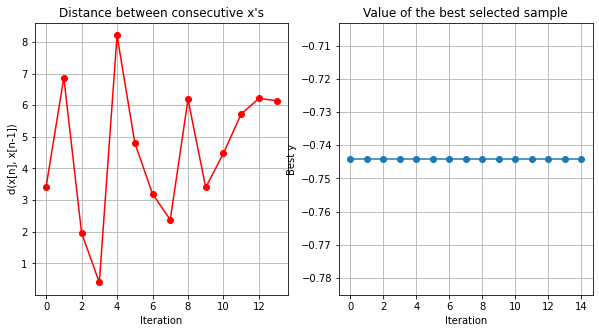

In [14]:
bo.plot_convergence()

In [15]:
best_hyperparameters

array([0.31302145, 8.98283444, 8.85279918])

In [ ]:

def objective_function(x, kernel_type):
    if x.ndim > 1:
        x = x.flatten()
    # x is a list of hyperparameters
    if kernel_type == 'RatQuad':
        variance, lengthscale, alpha = x[0], x[1], x[2]
    else:
        variance, lengthscale = x[0], x[1]
    
    # Initialize a GP model with the given hyperparameters and kernel type
    gp = GaussianProcess()
    if kernel_type == 'Matern52':
        kernel = GPy.kern.Matern52(input_dim=gp.space.model_dimensionality, 
                                   variance=variance, 
                                   lengthscale=lengthscale)
    elif kernel_type == 'linear':
        kernel = GPy.kern.Linear(input_dim=gp.space.model_dimensionality,
                                 variances=variance)
    elif kernel_type == 'RatQuad':
        kernel = GPy.kern.RatQuad(input_dim=gp.space.model_dimensionality,
                                    variance=variance,
                                    lengthscale=lengthscale,
                                    power=alpha)
    else:
        raise ValueError("Invalid kernel type")

    gp.update_model_with_kernel(kernel)
    # Calculate the utility using the expert data and the GP model
    recorded_points = expert_data[["error_before_right_timing", "error_before_right_pitch","practice_mode", "bpm","utility"]]
    policy_diff = policy_diff_for_single_gp(gp, recorded_points)
    return -policy_diff[0]


    


In [14]:
expert_data["utility"] = expert_data.apply(lambda row: error_diff_to_utility_for_opt(row["error_before_right_pitch"],
                                                                                row["error_after_right_pitch"],
                                                                                row["error_before_right_timing"],
                                                                                row["error_after_right_timing"]),
                                                axis=1)




In [ ]:
from GPyOpt.methods import BayesianOptimization
from statistics import mean 
kernel_types = ['Matern52', 'linear', 'RatQuad']
rqk_bounds = [{'name': 'variance', 'type': 'continuous', 'domain': (0.01, 1)},
          {'name': 'lengthscale', 'type': 'continuous', 'domain': (0.1, 10)},
          {'name': 'alpha', 'type': 'continuous', 'domain': (0.1, 10)}]

bounds = [{'name': 'variance', 'type': 'continuous', 'domain': (0.01, 1)},
          {'name': 'lengthscale', 'type': 'continuous', 'domain': (0.1, 10)}]

best_gp_dict ={}
best_gp_dict_policy = {}
for kernel_type in kernel_types:

    obj_func = lambda x: objective_function(x, kernel_type)
    if kernel_type == 'RatQuad':
        bounds_ = rqk_bounds
    else:
        bounds_ = bounds
    bo = BayesianOptimization(f=obj_func,
                              domain=bounds_,
                              acquisition_type='EI',
                              acquisition_jitter=0.05,
                              num_cores=1)
    # Run the optimization
    bo.run_optimization(max_iter=10)
    # Get the best set of hyperparameters
    best_hyperparameters = bo.x_opt
    best_mean_policy_diff = - bo.fx_opt
    best_gp_dict[kernel_type] = best_hyperparameters
    best_gp_dict_policy[kernel_type] = best_mean_policy_diff

In [22]:
best_gp_dict

{'Matern52': array([0.50587718, 1.35027655, 0.23055271]),
 'linear': array([0.45373768, 8.3108493 , 7.66762958])}

In [23]:
best_gp_dict_policy

{'Matern52': 0.7441428571428564, 'linear': 0.7441428571428564}

1. create different kernels optimization process
why are h-p are optimized for kernels they do not required
why the diff is the same for kernels